# Estimación de parámetros
## Movimiento Browninano Geométrico

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Lectura de datos
La base de datos fue obtenida de Bloomberg, tiene 200 observaciones en el tiempo.

In [20]:
X = pd.read_csv('datos.csv')['BABA']
X = X.reindex(index=X.index[::-1])
X = np.array(X)
N = len(X)
R = np.zeros(N)
# Retornos instantáneos
for j in range(1,N):
        R[j-1] = (X[j] - X[j-1])/X[j-1]

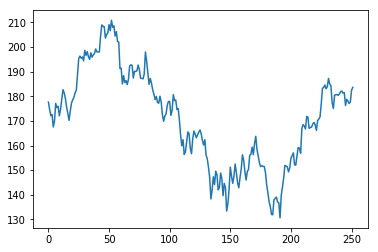

In [31]:
plt.plot(X)
plt.show()

## Tests de normalidad
Aplicaremos los test de Jarque-Bera, Shappiro Wilks y Lilliefors a los retornos de la base de datos

In [35]:
jb = stats.jarque_bera(R)
lilie = lilliefors(R)
shapiro = stats.shapiro(R)

In [36]:
df = pd.DataFrame()
df['Jarque Bera'] = [1 if jb[1]<0.03 else 0]
df['Shapiro Wilks'] = [1 if shapiro[1]<0.03 else 0]
df['Lilliefors'] = [1 if lilie[1]<0.05 else 0]
df

,Jarque Bera,Shapiro Wilks,Lilliefors
0,0,0,1


## Dimensión fractal

In [23]:
def hFD(a, k_max): 
# Higuchi FD
    L = []
    x = []
    N = len(a)

    for k in range(1,k_max):
        Lk = 0
        for m in range(0,k):
            #we pregenerate all idxs
            idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
            Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
            Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
            Lk += Lmk

        L.append(np.log(Lk/(m+1)))
        x.append([np.log(1.0/ k), 1])

    (p, r1, r2, s)=np.linalg.lstsq(x, L)
    return p[0]

In [24]:
hFD(X, 8)

1.5556692952844957

In [25]:
def hurst(signal):
    tau = []; lagvec = []

    #  Step through the different lags
    for lag in range(2,20):

    #  produce price difference with lag
        pp = np.subtract(signal[lag:],signal[:-lag])

    #  Write the different lags into a vector
        lagvec.append(lag)

    #  Calculate the variance of the difference vector
        tau.append(np.std(pp))

    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)

    # calculate hurst
    hurst = m[0]

    return hurst

In [26]:
hurst(X)

0.48054957910064966

## Estimación de parámetros
Ajustaremos nuestros datos a un Movimiento Browniano Geométrico:

$$X_t = e^{\mu t + \sigma B_t}$$


In [27]:
dt = 1/len(R)
media = np.mean(R)
varianza = np.var(R)
mu = media/dt
sigma = np.sqrt(varianza/dt)
print('mu: '+str(mu)+'\n'+'sigma: '+str(sigma))

mu: 0.09179175783287559
sigma: 0.34275669927046837


In [28]:
# Parametros
N = 100
dt = 1/252
#mu = 0.5
sg = sigma
# Condicion inicial
X0 = 10
S = np.zeros(N)
S[0] = X0
for j in range(1,N):
    S[j] = S[j-1] + mu*S[j-1]*dt + sg*S[j-1]*np.sqrt(dt)*np.random.normal()

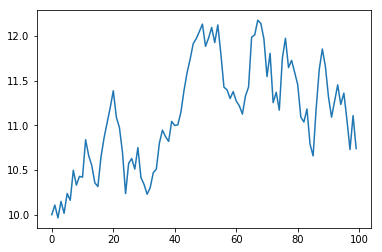

In [29]:
plt.plot(S)